# Week 9-1: Unsupervised Machine Learning

Van Pjotr en Sennen.

Deze week hebben we het over ongesuperviseerde machine learning. Dit is een vorm van machine learning waarbij we geen gelabelde data hebben. Dit betekent dat we geen data hebben waarbij we weten wat de juiste output is. In plaats daarvan gaan we op zoek naar patronen in de data. Dit kan bijvoorbeeld zijn dat we clusters van data vinden, of dat we de data kunnen reduceren naar een kleinere dimensie.

Maar deze keer gaan we clustering gebruiken, een techniek waarbij we data in groepen verdelen. Dit kan bijvoorbeeld handig zijn als we een dataset hebben met verschillende soorten bloemen, en we willen weten welke bloemen bij elkaar horen. Of als we een dataset hebben met verschillende soorten klanten, en we willen weten welke klanten bij elkaar horen.

PR9-1: Great Outdoors wil graag weten in welke segmenten verkoopafdelingen (‘sales_branches’) opgedeeld kan worden. Er bestaan al retailersegmenten (table ‘retailer_segment’), Great Outdoors wil dus óók segmenten creëren voor verkoopafdelingen:
- Pas waar nodig Dummy Encoding toe.
- Train het initiële clustermodel.
- Experimenteer met meerdere k’s door het berekenen van de inter- en intraclusterafstand.

Maar eerst een voorbeeld met de titanic.

## Bibliotheken importeren

In [66]:
import pandas as pd
import sqlite3
from sklearn.cluster import KMeans
import math
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.simplefilter('ignore')

## Data inlezen en kolommen selecteren

In [67]:
df = pd.read_csv("data/titanic2.csv", sep = ';')
df = df.filter(regex='^(?!Unnamed).*$')
df

,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Age
0,1,3,Braund; Mr. Owen Harris,male,1,0,A/5 21171,7.25,NaN,S,0,22
1,2,1,Cumings; Mrs. John Bradley (Florence Briggs Th...,female,1,0,PC 17599,712.833,C85,C,1,38
2,3,3,Heikkinen; Miss. Laina,female,0,0,STON/O2. 3101282,7.925,NaN,S,1,26
3,4,1,Futrelle; Mrs. Jacques Heath (Lily May Peel),female,1,0,113803,53.1,C123,S,1,35
4,5,3,Allen; Mr. William Henry,male,0,0,373450,8.05,NaN,S,0,35
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,Montvila; Rev. Juozas,male,0,0,211536,13,NaN,S,0,27
887,888,1,Graham; Miss. Margaret Edith,female,0,0,112053,30,B42,S,1,19
888,889,3,"Johnston; Miss. Catherine Helen ""Carrie""",female,1,2,W./C. 6607,23.45,NaN,S,0,15
889,890,1,Behr; Mr. Karl Howell,male,0,0,111369,30,C148,C,1,26


In [68]:
df = df.loc[:, ['Pclass', 'Sex', 'Age', 'Survived']]
df

,Pclass,Sex,Age,Survived
0,3,male,22,0
1,1,female,38,1
2,3,female,26,1
3,1,female,35,1
4,3,male,35,0
...,...,...,...,...
886,2,male,27,0
887,1,female,19,1
888,3,female,15,0
889,1,male,26,1


## One-hot encoding van onafhankelijke niet-numerieke variabelen

In [69]:
df['Pclass'] = df['Pclass'].astype(str)
df.dtypes

Pclass      object
Sex         object
Age          int64
Survived     int64
dtype: object

In [70]:
dummies_dataframe = pd.get_dummies(df.loc[:, ['Sex', 'Pclass']])
dummies_dataframe

,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,False,True,False,False,True
1,True,False,True,False,False
2,True,False,False,False,True
3,True,False,True,False,False
4,False,True,False,False,True
...,...,...,...,...,...
886,False,True,False,True,False
887,True,False,True,False,False
888,True,False,False,False,True
889,False,True,True,False,False


In [71]:
df = pd.concat([df, dummies_dataframe], axis = 1)
df = df.drop(['Sex'], axis = 1)
df = df.loc[:, ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Age', 'Survived']]
df

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age,Survived
0,False,False,True,False,True,22,0
1,True,False,False,True,False,38,1
2,False,False,True,True,False,26,1
3,True,False,False,True,False,35,1
4,False,False,True,False,True,35,0
...,...,...,...,...,...,...,...
886,False,True,False,False,True,27,0
887,True,False,False,True,False,19,1
888,False,False,True,True,False,15,0
889,True,False,False,False,True,26,1


## Clusteringmodel bouwen met 2 dimensies

In [72]:
df_2d = df.loc[:, ['Age', 'Survived']]
df_2d

,Age,Survived
0,22,0
1,38,1
2,26,1
3,35,1
4,35,0
...,...,...
886,27,0
887,19,1
888,15,0
889,26,1


In [73]:
kmeans = KMeans(n_clusters = 3, random_state = 42)
kmeans.fit_predict(df_2d)

array([0, 2, 2, 2, 2, 2, 1, 0, 2, 0, 0, 1, 0, 2, 0, 1, 0, 2, 2, 2, 2, 2,
       0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 0, 0, 0, 1, 2, 1, 2, 0, 2, 0, 0, 0, 2, 1, 0, 2, 2,
       2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 0, 2, 0, 2,
       0, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2,
       1, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 1, 2, 2, 1, 0, 2, 2, 2, 1, 2, 0,
       1, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 1, 0, 1, 2,
       0, 1, 0, 2, 0, 0, 1, 2, 2, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 1, 0,
       0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 1, 1, 0, 2,
       0, 2, 2, 0, 2, 1, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 1, 2, 2, 0, 0, 0, 0, 2, 2, 2, 1, 0, 2, 2, 1, 0, 0, 2, 2, 2,
       2, 0, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 0, 1, 2,
       2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 0, 2, 2,
       2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 1, 1, 1,

In [74]:
kmeans_centra = pd.DataFrame(kmeans.cluster_centers_)
kmeans_centra

,0,1
0,15.992481,0.379699
1,54.156682,0.354839
2,31.632353,0.401961


In [75]:
for i in range(len(kmeans_centra.columns)):
    kmeans_centra = kmeans_centra.rename(columns = {i : f'{df_2d.columns[i]}'})
    
kmeans_centra

,Age,Survived
0,15.992481,0.379699
1,54.156682,0.354839
2,31.632353,0.401961


In [76]:
for src_index, _ in df_2d.iterrows():
    euclidian_distances = dict()
    print(f"Afstand van bronindex {src_index} tot...")

    for centrumindex, _ in kmeans_centra.iterrows():
        print(f"\tCentrumindex {centrumindex}:")
        euclidian_sum = 0

        for column_name in kmeans_centra.columns:
            current_difference = df_2d.at[src_index, column_name] - kmeans_centra.at[centrumindex, column_name]
            print(f'\t\t{df_2d.at[src_index, column_name]} - {kmeans_centra.at[centrumindex, column_name]} = {current_difference}')
            euclidian_sum += current_difference ** 2
        
        print(f'\tTotale euclidische som: {euclidian_sum}')
        euclidian_distance = math.sqrt(euclidian_sum)
        print(f'\tEuclidische afstand: {euclidian_distance}')
        euclidian_distances[centrumindex] = euclidian_distance
        print('------------------------------------------------')
    
    print(euclidian_distances)
    centrum_number = min(euclidian_distances, key = euclidian_distances.get)
    print(centrum_number)
    df_2d.at[src_index, 'Centrum'] = centrum_number
    print("================================================")

df_2d

Afstand van bronindex 0 tot...
	Centrumindex 0:
		22 - 15.992481203007529 = 6.007518796992471
		0 - 0.3796992481203007 = -0.3796992481203007
	Totale euclidische som: 36.234453615240994
	Euclidische afstand: 6.0195060939616125
------------------------------------------------
	Centrumindex 1:
		22 - 54.156682027649765 = -32.156682027649765
		0 - 0.3548387096774193 = -0.3548387096774193
	Totale euclidische som: 1034.178109537259
	Euclidische afstand: 32.15863973393867
------------------------------------------------
	Centrumindex 2:
		22 - 31.63235294117647 = -9.632352941176471
		0 - 0.4019607843137254 = -0.4019607843137254
	Totale euclidische som: 92.94379565551712
	Euclidische afstand: 9.640736261070371
------------------------------------------------
{0: 6.0195060939616125, 1: 32.15863973393867, 2: 9.640736261070371}
0
Afstand van bronindex 1 tot...
	Centrumindex 0:
		38 - 15.992481203007529 = 22.00751879699247
		1 - 0.3796992481203007 = 0.6203007518796992
	Totale euclidische som: 484.

,Age,Survived,Centrum
0,22,0,0.0
1,38,1,2.0
2,26,1,2.0
3,35,1,2.0
4,35,0,2.0
...,...,...,...
886,27,0,2.0
887,19,1,0.0
888,15,0,0.0
889,26,1,2.0


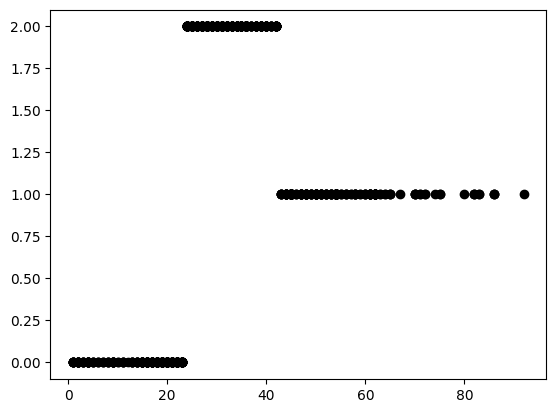

In [77]:
plt.scatter(df_2d['Age'], df_2d['Centrum'], color = 'k')
plt.show()

In [78]:
df_2d.groupby('Centrum', as_index = False)['Centrum'].count()

,Centrum
0,266
1,217
2,408


## Clusteringmodel bouwen met meer dan 2 dimensies (alle kolommen uit de dataset)

### Centra berekenen

In [79]:
kmeans = KMeans(n_clusters = 6, random_state = 42)
prediction_results = kmeans.fit_predict(df)
prediction_results

array([0, 1, 2, 2, 2, 2, 5, 4, 2, 0, 4, 5, 0, 1, 0, 5, 4, 2, 2, 2, 2, 2,
       0, 2, 4, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 0, 4, 0, 1, 2, 5, 2, 0, 2, 4, 4, 0, 1, 1, 4, 1, 1,
       2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 1, 1, 3, 2, 0, 2, 0, 2, 0, 2, 0, 0,
       0, 0, 2, 0, 1, 2, 5, 0, 3, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 3, 2, 0, 4, 0, 3, 2, 2, 5, 4, 2, 0, 2, 1, 2, 0,
       1, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 4, 2, 1, 5, 0, 5, 1,
       0, 5, 0, 2, 0, 0, 1, 1, 2, 0, 4, 4, 0, 1, 0, 2, 5, 4, 4, 0, 5, 0,
       0, 5, 2, 2, 0, 0, 4, 4, 4, 0, 0, 1, 1, 2, 2, 0, 0, 4, 1, 5, 0, 1,
       0, 0, 2, 0, 2, 1, 0, 4, 2, 2, 0, 1, 0, 2, 0, 2, 1, 2, 2, 1, 2, 2,
       0, 2, 5, 1, 1, 0, 0, 0, 0, 2, 2, 2, 5, 4, 0, 2, 1, 4, 0, 2, 2, 2,
       2, 0, 2, 1, 0, 0, 2, 5, 2, 2, 5, 2, 1, 2, 2, 2, 2, 5, 2, 4, 5, 1,
       2, 2, 0, 0, 5, 2, 2, 0, 1, 2, 2, 5, 1, 2, 4, 2, 5, 2, 0, 0, 2, 2,
       2, 0, 1, 0, 2, 0, 2, 0, 0, 2, 0, 4, 5, 5, 5,

In [80]:
df['Centrum'] = prediction_results
df

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age,Survived,Centrum
0,False,False,True,False,True,22,0,0
1,True,False,False,True,False,38,1,1
2,False,False,True,True,False,26,1,2
3,True,False,False,True,False,35,1,2
4,False,False,True,False,True,35,0,2
...,...,...,...,...,...,...,...,...
886,False,True,False,False,True,27,0,2
887,True,False,False,True,False,19,1,0
888,False,False,True,True,False,15,0,0
889,True,False,False,False,True,26,1,2


### De juiste centra toewijzen aan rijen uit de dataset

In [81]:
df.groupby('Centrum', as_index = False)['Centrum'].count()

,Centrum
0,265
1,145
2,285
3,22
4,61
5,113


# De Sales Branches clusteren


In [82]:
# Verbinding maken met de databases
conn_sales = sqlite3.connect('data/go_sales.sqlite')
conn_crm = sqlite3.connect('data/go_crm.sqlite')
conn_staff = sqlite3.connect('data/go_staff.sqlite')

# Gegevens ophalen uit de databases
sales_branch = pd.read_sql_query("SELECT * FROM sales_branch", conn_staff)
country1 = pd.read_sql_query("SELECT * FROM country", conn_sales)
country2 = pd.read_sql_query("SELECT * FROM country", conn_crm)
territory = pd.read_sql_query("SELECT * FROM sales_territory", conn_crm)

Hier gaan we de data van de great outdoors inlezen en bepaalde data dropen.

In [83]:
country = country1[['CURRENCY_NAME', 'LANGUAGE']]
country = pd.concat([country2, country], axis = 1)
sales_branch.drop('TRIAL633', axis=1, inplace=True)
country.drop('TRIAL219', axis=1, inplace=True)
territory.drop('TRIAL222', axis=1, inplace=True)

Nu gaan we mergen.

In [84]:
table = pd.merge(country, territory, left_on='SALES_TERRITORY_CODE', right_on='SALES_TERRITORY_CODE', how='left')
table = pd.merge(sales_branch, table, left_on='COUNTRY_CODE', right_on='COUNTRY_CODE', how='left')
table

,SALES_BRANCH_CODE,ADDRESS1,ADDRESS2,CITY,REGION,POSTAL_ZONE,COUNTRY_CODE,COUNTRY_EN,FLAG_IMAGE,SALES_TERRITORY_CODE,CURRENCY_NAME,LANGUAGE,TERRITORY_NAME_EN
0,13,Schwabentor 35,None,Hamburg,None,D-22529,2,Germany,F02,6,marks,EN,Central Europe
1,14,Leopoldstraße 36,None,München,None,D-81241,2,Germany,F02,6,marks,EN,Central Europe
2,15,Isafjordsgatan 30 C,None,Kista,None,S-164 40,10,Sweden,F10,5,krona,EN,Northern Europe
3,17,"7800, 756 - 6th Avenue. S.W.",None,Calgary,Alberta,T2P 3Z0,4,Canada,F04,1,dollars,EN,Americas
4,18,789 Yonge Street,None,Toronto,Ontario,M2M 4K8,4,Canada,F04,1,dollars,EN,Americas
5,19,1288 Dorchester Avenue,None,Boston,Massachusetts,02133,3,United States,F03,1,dollars,EN,Americas
6,20,299 Yale Avenue,None,Seattle,Washington,98139,3,United States,F03,1,dollars,EN,Americas
7,21,1288 South Barrington Ave.,None,Los Angeles,California,90072,3,United States,F03,1,dollars,EN,Americas
8,22,10032 NW 186th,None,Miami,Florida,33024,3,United States,F03,1,dollars,EN,Americas
9,23,"6c, rue de l'Église",None,Lyon,None,F-69002,1,France,F01,6,francs,EN,Central Europe


In [85]:
table = table[['CURRENCY_NAME', 'COUNTRY_EN', 'TERRITORY_NAME_EN']]
df = pd.get_dummies(table)  # Dummy encoding
df.dropna(inplace=True)  # Optioneel: verwijder rijen met ontbrekende waarden

table = pd.concat([table, df], axis=1)
table

,CURRENCY_NAME,COUNTRY_EN,TERRITORY_NAME_EN,CURRENCY_NAME_dollars,CURRENCY_NAME_francs,CURRENCY_NAME_guilders,CURRENCY_NAME_krona,CURRENCY_NAME_lira,CURRENCY_NAME_markka,CURRENCY_NAME_marks,...,COUNTRY_EN_Sweden,COUNTRY_EN_Switzerland,COUNTRY_EN_Taiwan,COUNTRY_EN_United Kingdom,COUNTRY_EN_United States,TERRITORY_NAME_EN_Americas,TERRITORY_NAME_EN_Asia Pacific,TERRITORY_NAME_EN_Central Europe,TERRITORY_NAME_EN_Northern Europe,TERRITORY_NAME_EN_Southern Europe
0,marks,Germany,Central Europe,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
1,marks,Germany,Central Europe,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
2,krona,Sweden,Northern Europe,False,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,True,False
3,dollars,Canada,Americas,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,dollars,Canada,Americas,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
5,dollars,United States,Americas,True,False,False,False,False,False,False,...,False,False,False,False,True,True,False,False,False,False
6,dollars,United States,Americas,True,False,False,False,False,False,False,...,False,False,False,False,True,True,False,False,False,False
7,dollars,United States,Americas,True,False,False,False,False,False,False,...,False,False,False,False,True,True,False,False,False,False
8,dollars,United States,Americas,True,False,False,False,False,False,False,...,False,False,False,False,True,True,False,False,False,False
9,francs,France,Central Europe,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [86]:
# Train het clustermodel
kmeans = KMeans(n_clusters=4, random_state=42)
prediction_results = kmeans.fit_predict(df)
prediction_results

kmeans_centra = pd.DataFrame(kmeans.cluster_centers_)
kmeans_centra

for i in range(len(kmeans_centra.columns)):
    kmeans_centra = kmeans_centra.rename(columns = {i : f'{df.columns[i]}'})
    
kmeans_centra

,CURRENCY_NAME_dollars,CURRENCY_NAME_francs,CURRENCY_NAME_guilders,CURRENCY_NAME_krona,CURRENCY_NAME_lira,CURRENCY_NAME_markka,CURRENCY_NAME_marks,CURRENCY_NAME_new dollar,CURRENCY_NAME_pesetas,CURRENCY_NAME_pesos,...,COUNTRY_EN_Sweden,COUNTRY_EN_Switzerland,COUNTRY_EN_Taiwan,COUNTRY_EN_United Kingdom,COUNTRY_EN_United States,TERRITORY_NAME_EN_Americas,TERRITORY_NAME_EN_Asia Pacific,TERRITORY_NAME_EN_Central Europe,TERRITORY_NAME_EN_Northern Europe,TERRITORY_NAME_EN_Southern Europe
0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e-01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.0,5.000000e-01,6.938894e-18,6.938894e-18,6.938894e-18,6.938894e-18,2.500000e-01,6.938894e-18,6.938894e-18,6.938894e-18,...,6.938894e-18,1.250000e-01,6.938894e-18,2.500000e-01,2.775558e-17,5.551115e-17,2.775558e-17,1.000000e+00,1.387779e-17,1.387779e-17
2,1.0,2.775558e-17,6.938894e-18,6.938894e-18,6.938894e-18,6.938894e-18,1.387779e-17,6.938894e-18,6.938894e-18,6.938894e-18,...,6.938894e-18,6.938894e-18,6.938894e-18,1.387779e-17,5.714286e-01,8.571429e-01,1.428571e-01,5.551115e-17,1.387779e-17,1.387779e-17
3,0.0,2.775558e-17,9.090909e-02,9.090909e-02,9.090909e-02,9.090909e-02,1.387779e-17,9.090909e-02,9.090909e-02,6.938894e-18,...,9.090909e-02,6.938894e-18,9.090909e-02,1.387779e-17,2.775558e-17,5.551115e-17,4.545455e-01,5.551115e-17,2.727273e-01,2.727273e-01


In [87]:
for src_index, _ in df.iterrows():
    euclidian_distances = dict()
    print(f"Afstand van bronindex {src_index} tot...")

    for centrumindex, _ in kmeans_centra.iterrows():
        print(f"\tCentrumindex {centrumindex}:")
        euclidian_sum = 0

        for column_name in kmeans_centra.columns:
            current_difference = df.at[src_index, column_name] - kmeans_centra.at[centrumindex, column_name]
            print(f'\t\t{df.at[src_index, column_name]} - {kmeans_centra.at[centrumindex, column_name]} = {current_difference}')
            euclidian_sum += current_difference ** 2
        
        print(f'\tTotale euclidische som: {euclidian_sum}')
        euclidian_distance = math.sqrt(euclidian_sum)
        print(f'\tEuclidische afstand: {euclidian_distance}')
        euclidian_distances[centrumindex] = euclidian_distance
        print('------------------------------------------------')
    
    print(euclidian_distances)
    centrum_number = min(euclidian_distances, key = euclidian_distances.get)
    print(centrum_number)
    df.at[src_index, 'Centrum'] = centrum_number
    print("================================================")

df

Afstand van bronindex 0 tot...
	Centrumindex 0:
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		True - 0.0 = 1.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.5 = -0.5
		False - 0.0 = 0.0
		False - 0.5 = -0.5
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.5 = -0.5
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		True - 0.0 = 1.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.5 = -0.5
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 1.0 = -1.0
		False - 0.0 = 0.0
		True - 0.0 = 1.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
	Totale euclidische som: 5.0
	Euclidische afstand: 2.23606797749979
------------------------------------------------
	Centrumindex

,CURRENCY_NAME_dollars,CURRENCY_NAME_francs,CURRENCY_NAME_guilders,CURRENCY_NAME_krona,CURRENCY_NAME_lira,CURRENCY_NAME_markka,CURRENCY_NAME_marks,CURRENCY_NAME_new dollar,CURRENCY_NAME_pesetas,CURRENCY_NAME_pesos,...,COUNTRY_EN_Switzerland,COUNTRY_EN_Taiwan,COUNTRY_EN_United Kingdom,COUNTRY_EN_United States,TERRITORY_NAME_EN_Americas,TERRITORY_NAME_EN_Asia Pacific,TERRITORY_NAME_EN_Central Europe,TERRITORY_NAME_EN_Northern Europe,TERRITORY_NAME_EN_Southern Europe,Centrum
0,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,1.0
1,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,1.0
2,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,3.0
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,2.0
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,2.0
5,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,False,False,False,False,2.0
6,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,False,False,False,False,2.0
7,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,False,False,False,False,2.0
8,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,False,False,False,False,2.0
9,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,1.0


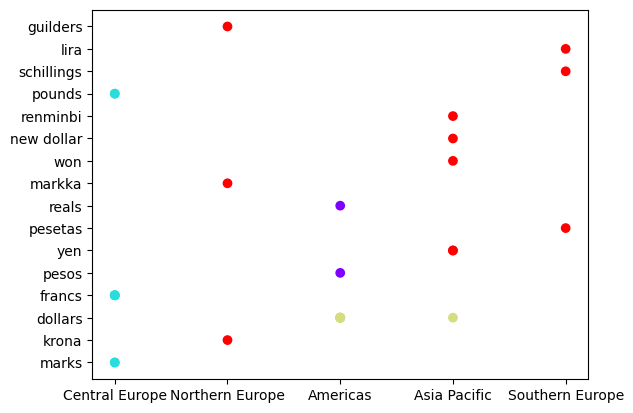

In [88]:
plt.scatter(table['TERRITORY_NAME_EN'], table['CURRENCY_NAME'], c = prediction_results, cmap = 'rainbow')
plt.show()